# <center> Assignment 3 - Feed Forward Neural Network
###### Author: Rudraksh Kapil - 177154
In this notebook the following tasks are accomplished:
    1. General definitions and functions for feed forward neural network - Running on XOR
    2. Handwritten digit recognition.
    3. Handwritten character recognition.

In [5]:
# import statements
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tqdm import tqdm

### 1. Making Network

###### Activation Function
We use a sigmoid activation function to calculate output of a unit.

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

###### Prediction Function
Predicts output given X and weights; returns accuracy. The y value to be passed to it should be in one-hot encoding format (OH format).

In [7]:
# checks accuracy
# bias is set to True if we're using 2 bit truth tables as input 
#(3rd bias term x0 is to be appended)
def predict(X, y, w1, w2, verbose=True, bias=True, show_all=False):
    # prediction in OH format will be stored in this list for each example
    y_pred = [] 
    
    # run through the network (forward pass only) for each X sample to get prediction
    for x in X:
        h = sigmoid(x.dot(w1.T))
        if (bias):
            temp_h = np.append(np.ones(1), h) # we dont want to add a bias term to h itself
        else:
            temp_h = h
        o = sigmoid(temp_h.dot(w2.T))
        
        # store prediction for this sample
        y_pred.append(o)
        
    # convert Y and Y_pred back from OH format to 1d array
    # our prediction is the index with highest value in y_pred hence using argmax
    y = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
                
    # for debugging print the labels for all pictures
    if show_all:
        for idx,x in enumerate(X):
            print(f"Predicted => {y_pred[idx]}, Actual => {y[idx]}")
            plt.imshow(x.reshape(28,28))
            plt.show()
    
    # calculate and return accuracy - this is why we had to reconvert back from OH format
    accuracy = np.mean(y_pred==y)
    if (verbose):
        print(f"Accuracy => {accuracy*100}")
    return accuracy

###### Backprop Training Function
We use a two layer network with variable number of input, hidden, and output units. Returns the weights of the two layers as well as a trace of the accuracy on the training set during training.

In [8]:
# We use a parameters dictionary becuase there are so many parameters to pass
def backprop(X, Y, params):
    
    # extract parameters
    X_test = params.get('X_test', None) # test set images
    Y_test = params.get('Y_test', None) # test set labels
    n_hid = params.get('n_hid', 2)      # num hidden units - default = 2
    lr = params.get('lr', 0.2)          # learning rate
    w_init = params.get('w_init', None) # weight initiliases (None->random)
    w_scale = params.get('w_scale', 1)  # value to divide weights with
    n_iters = params.get('n_iters', 10) # num of iterations to train for
    batch = params.get('batch', False)  # batch update or stochastic 
    bias = params.get('bias', True)     # do we have to add bias dim
    
    # append ones col to X if needed (bias is True)
    if bias:
        ones_col = np.ones((X.shape[0],1))
        X = np.concatenate((ones_col,X), axis=1)
    
    # bias_int is integer version of boolean bias
    bias_int = 1 if bias else 0 # add 1 to weigt dimension if bias is needed
    
    # create weights - if no init given, we randomise to v small values
    if w_init is not None:
        w1 = np.ones((n_hid,X.shape[1])) * w_init
        w2 = np.ones((Y.shape[1],n_hid+bias_int)) * w_init
    else:
        w1 = np.random.uniform(size=(n_hid,X.shape[1])) / w_scale
        w2 = np.random.uniform(size=(Y.shape[1],n_hid+bias_int)) / w_scale
            
    # lists to store accuracies
    accuracies = []
    test_accuracies = []
    
    # loop over number of iterations
    for i in tqdm(range(n_iters)):
        
        # lists to store histories for batch update
        history_w1 = [] 
        history_w2 = []
        
        # for each training example 
        for idx, (x,y) in enumerate(zip(X,Y)):
            ### FORWARD PASS
            h = sigmoid(x.dot(w1.T))
            if bias:
                temp_h = np.append(np.ones(1), h) # becuase we dont want to add a bias term to h itself
            else:
                temp_h = h
            o = sigmoid(temp_h.dot(w2.T))
            
            ### BACKWARD PASS
            do = o*(1-o)*(y-o)
            dh = h * (1-h) * do.dot(w2[:,bias_int:]) # skip bias dim if it exists
            
            ### WEIGHT CHANGES
            dw2 = lr * do.reshape(-1,1) * temp_h
            dw1 = lr * dh.reshape(-1,1) *(x) 

            # store deltas if batch update required
            if batch == True:
                history_w1.append(dw1)
                history_w2.append(dw2)
            
            # otherwise stochastic update -> update here
            else:
                ### WEIGHT UPDATES
                w2 += dw2
                w1 += dw1
                
        # for bacth update -> update here
        if batch is True:
            ### WEIGHT UPDATES
            w2 += sum(history_w2)
            w1 += sum(history_w1)

        # Check accuracy while training
        accuracies.append(predict(X,Y,w1,w2,verbose=False,bias=bias))
        
        # if test set is provided, check accuracy on that also
        if X_test is not None:
            test_accuracies.append(predict(X_test,Y_test,w1,w2,verbose=False,bias=bias))
      
    # return according to if test set was provided
    if X_test is not None:
        return w1, w2, accuracies, test_accuracies
    else:
        return w1, w2, accuracies 

### 1. Running on XOR Truth Table
We test our functions on 2 bit XOR truth table. Note that test data will be same as train data so training accuracy is equivalent to testing accuracy.

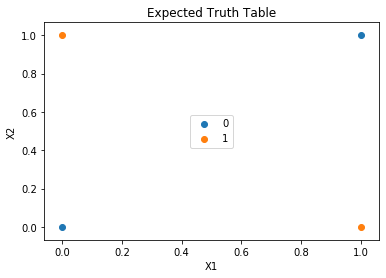

In [9]:
# Truth table - currently XOR but can be changed to any other function like XNOR
TT = np.asarray([[0,0,0],    
                 [0,1,1], 
                 [1,0,1],
                 [1,1,0]])

### Visualise the truth table
# X values are first 2 cols, y is final col (output)
X = TT[:,:2]
y = TT[:,-1]
    
plt.title("Expected Truth Table")
plt.xlabel('X1')
plt.ylabel('X2')
    
# separate the X values by output (for coloring in plots)
X_zeros = X[y==0,:]
X_ones  = X[y==1,:]

# plot X values and color as y value
plt.scatter(X_zeros[:,0], X_zeros[:,1], label = '0')
plt.scatter(X_ones[:,0], X_ones[:,1], label = '1')  
plt.legend(loc='center')

plt.show()

100%|██████████| 10000/10000 [00:02<00:00, 3626.30it/s]


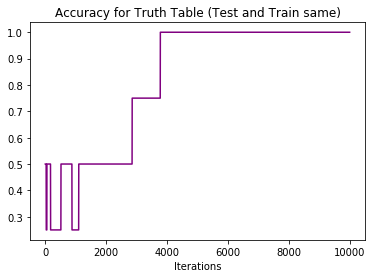

Highest accuracy => 1.0
Final Accuracy => 1.0
[[ 3.05050044  6.39399952 -6.13898707]
 [-3.59446521  6.69147009 -6.85112036]] [[-3.54171113  7.46033187 -7.69206585]
 [ 3.54726735 -7.47193344  7.70405844]]


In [10]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 2,
    'lr'      : 0.2,          
    'w_init'  : None,
    'w_scale' : 1,
    'n_iters' : 10000, 
    'batch'   : False, 
    'bias'    : True
}

# Inputs: get X and y from truth table
X = TT[:,:2] # first two columns
y = TT[:,-1] # last column

# convert y to one hot encoding (for our network to be general for any number of output units)
y_OH = np.zeros((y.size, y.max()+1))
y_OH[np.arange(y.size),y.reshape(-1)] = 1

# call backprop function
# our architechture here is 2 ip units, 2 hidden units and 2 output units
# giving a total size of 6 weights from ip to hidden and 6 from hidden to output
w1,w2,accuracies = backprop(X,y_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='purple')
plt.title('Accuracy for Truth Table (Test and Train same)')
plt.xlabel('Iterations')
plt.show()
print(f"Highest accuracy => {max(accuracies)}")
print(f"Final Accuracy => {accuracies[-1]}")
print(w1,w2)

### 2. Handwritten digit recognition

###### Get digits from MNIST Dataset 
We also show some images for visualisation. The data is loaded directly from keras.datasets becuase the actual files are too large to download and reupload during submission.

In [11]:
from tensorflow.python.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reduce sizes - make training faster while also giving decent accuracy
num_train = 1000
num_test = 100

X_train = X_train[:num_train]
Y_train = Y_train[:num_train]
X_test = X_test[:num_test]
Y_test = Y_test[:num_test]

# Convert y vectors to one hot vectors for our network to work
Y_train_OH = np.zeros((Y_train.size, Y_train.max()+1))
Y_train_OH[np.arange(Y_train.size),Y_train] = 1

Y_test_OH = np.zeros((Y_test.size, Y_test.max()+1))
Y_test_OH[np.arange(Y_test.size),Y_test] = 1

# flatten X and bring into [0,1] range
X_train = X_train.reshape(X_train.shape[0],-1) / 255
X_test = X_test.reshape(X_test.shape[0],-1) / 255

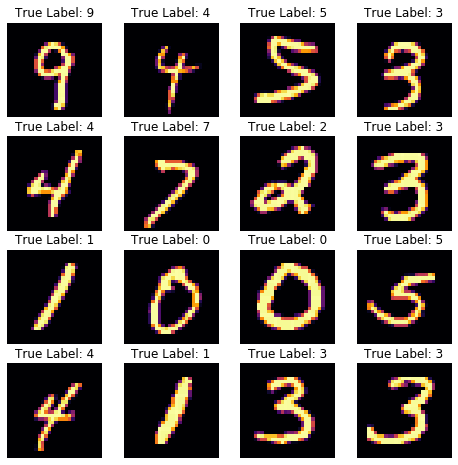

In [12]:
# Visualise:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    r = np.random.randint(X_train.shape[0])   # get a random image to show
    plt.title('True Label: '+str(Y_train[r])) # show its label as title
    plt.imshow(X_train[r].reshape(28,28), cmap='inferno')    # plot the image
plt.show()

100%|██████████| 500/500 [01:26<00:00,  5.80it/s]


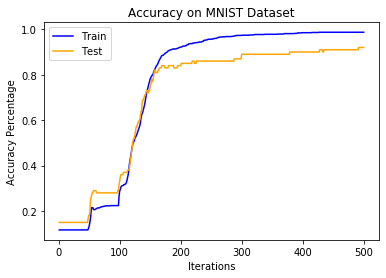

Highest Train accuracy => 98.7%
Highest Test accuracy => 92.0%

Final Train accuracy => 98.7%
Final Test Accuracy => 92.0%

Because of the data augmentation and because we took a small subset of the total data, the performance here is considerably poorer than on the non augmented (and smaller) MNIST dataset for digits above, requiring longer training which we have not done here due to hardware constraints (This itself took around an hour to train)
You can see that the curves are rising after 500 iterations, so for more number of iterations the performance is expected to increases (though probably not to the level of performance is part 2 above.) 


In [13]:
 # Hyperparameters - tune here
params = {
    'n_hid'   : 100,
    'lr'      : 0.01,          
    'w_init'  : None,
    'w_scale' : 10,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : False,    # no need for bias dimension here
    
    # we want to print test accuracy also:
    'X_test'  : X_test,
    'Y_test'  : Y_test_OH,
}

# call backprop function to train
# here our network is 784 (28*28) input units, 100 hidden units, and 10 output units
# the output is in OH format
w1,w2,accuracies,test_accuracies = backprop(X_train,Y_train_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='blue',label='Train')
plt.plot(epochs, test_accuracies, c='orange',label='Test')
plt.title('Accuracy on MNIST Dataset')
plt.xlabel('Iterations')
plt.ylabel('Accuracy Percentage')
plt.legend()
plt.show()

# print details
print(f"Highest Train accuracy => {max(accuracies)*100}%")
print(f"Highest Test accuracy => {max(test_accuracies)*100}%\n")
print(f"Final Train accuracy => {accuracies[-1]*100}%")
print(f"Final Test Accuracy => {test_accuracies[-1]*100}%")
print("\nBecause of the data augmentation and because we took a small subset of the total data, the performance here is considerably poorer than on the non augmented (and smaller) MNIST dataset for digits above, requiring longer training which we have not done here due to hardware constraints (This itself took around an hour to train)")
print("You can see that the curves are rising after 500 iterations, so for more number of iterations the performance is expected to increases (though probably not to the level of performance is part 2 above.) ")

### 3. Handwritten Character Recognition

###### Get letters from EMNIST Dataset 
We also show some images for visualisation. The data is loaded from csv files present in the same folder. Note that the csv files have been significantly reduced (ie fewer rows) for ease of submission - anyway we use only a small subset of the total images due to hardware constraints. The first column has Y values, and the rest of the 784 coloumns are the image. Also note that emnist images are rotated (data augmentation) so the images here may not look exactly like the corresponding letter from all angles.

In [45]:
# use pandas to read and convert to numpy
train = pd.read_csv("emnist-letters-train.csv").to_numpy()
test = pd.read_csv("emnist-letters-test.csv").to_numpy()

# extract the Xs and Ys
Y_train = train[:,0]
X_train = train[:,1:]
Y_test = test[:,0]
X_test = test[:,1:]

# reduce sizes further
num_train = 5000
num_test = 500

X_train = X_train[:num_train]
Y_train = Y_train[:num_train]
X_test = X_test[:num_test]
Y_test = Y_test[:num_test]

# Convert y vectors to one hot vectors for our network to work
Y_train_OH = np.zeros((Y_train.size, Y_train.max()+1))
Y_train_OH[np.arange(Y_train.size),Y_train] = 1

Y_test_OH = np.zeros((Y_test.size, Y_test.max()+1))
Y_test_OH[np.arange(Y_test.size),Y_test] = 1

# flatten X and bring into [0,1] range
X_train = X_train.reshape(X_train.shape[0],-1) / 255
X_test = X_test.reshape(X_test.shape[0],-1) / 255

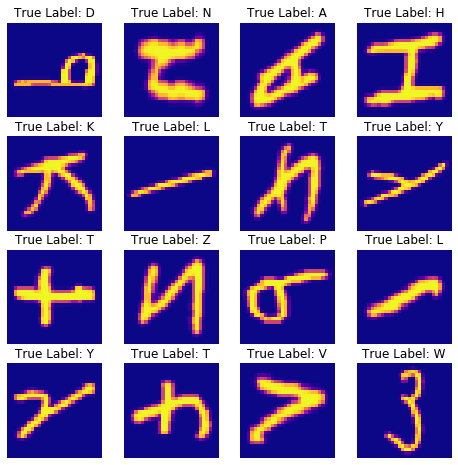

In [46]:
# Visualise:
# note that the images are flipped and rotated in the dataset itself, 
#  so the labels may not match from all angles. 
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.axis('off')
    r = np.random.randint(X_train.shape[0])   # get a random image to show
    plt.title('True Label: '+str(chr(ord('@')+Y_train[r]))) # show its label as title
    plt.imshow(X_train[r].reshape(28,28), cmap='plasma')    # plot the image
plt.show()

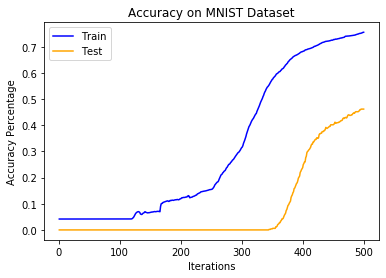

Highest Train accuracy => 75.58727326791555%
Highest Test accuracy => 46.2%

Final Train accuracy => 75.58727326791555%
Final Test Accuracy => 46.2%

Because of the data augmentation and because we took a small subset of the total data, the performance here is considerably poorer than on the non augmented (and smaller) MNIST dataset for digits above, requiring longer training which we have not done here due to hardware constraints (This itself took around an hour to train)
You can see that the curves are rising after 500 iterations, so for more number of iterations the performance is expected to increases (though probably not to the level of performance is part 2 above.) 


In [51]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 100,
    'lr'      : 0.01,          
    'w_init'  : None,
    'w_scale' : 10,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : False,    # no need for bias dimension here
    
    # we want to print test accuracy also:
    'X_test'  : X_test,
    'Y_test'  : Y_test_OH,
}

# call backprop function to train
# here our network is 784 (28*28) input units, 100 hidden units, and 10 output units
# the output is in OH format
w1,w2,accuracies,test_accuracies = backprop(X_train,Y_train_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='blue',label='Train')
plt.plot(epochs, test_accuracies, c='orange',label='Test')
plt.title('Accuracy on MNIST Dataset')
plt.xlabel('Iterations')
plt.ylabel('Accuracy Percentage')
plt.legend()
plt.show()

# print details
print(f"Highest Train accuracy => {max(accuracies)*100}%")
print(f"Highest Test accuracy => {max(test_accuracies)*100}%\n")
print(f"Final Train accuracy => {accuracies[-1]*100}%")
print(f"Final Test Accuracy => {test_accuracies[-1]*100}%")
print("\nBecause of the data augmentation and because we took a small subset of the total data, the performance here is considerably poorer than on the non augmented (and smaller) MNIST dataset for digits above, requiring longer training which we have not done here due to hardware constraints (This itself took around an hour to train)")
print("You can see that the curves are rising after 500 iterations, so for more number of iterations the performance is expected to increases (though probably not to the level of performance is part 2 above.) ")

###### <center> END OF ASSIGNMENT <br><br> Author: Rudraksh Kapil - 177154 <br><br> Thank you for reading :)